In [67]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-card-fraud-prediction-modified-data/credit_data_final.csv


In [2]:
path = os.path.join(r"/kaggle/input/credit-card-fraud-prediction-modified-data/credit_data_final.csv")
df = pd.read_csv(path)
print(df.shape)

(14446, 10)


In [3]:
df.head()

,trans_hour,purchase_category,city_population,purchase_city_lat,purchase_city_long,amount,age,occupation,merchant_name,is_fraud
0,0,3,145,64.7556,-165.6723,14.37,80,1,179,1
1,15,11,145,64.7556,-165.6723,966.11,80,1,564,1
2,22,9,145,64.7556,-165.6723,49.61,80,1,682,1
3,23,4,145,64.7556,-165.6723,295.26,80,1,537,1
4,23,5,145,64.7556,-165.6723,18.17,80,1,352,1


In [4]:
df['is_fraud'].value_counts()

is_fraud
0    12601
1     1845
Name: count, dtype: int64

The Class feature is imbalanced - Later on we will be using - RandomUndersampling, RandomOversampling ans SMOTE for handling the imbalance in the dataset

In [5]:
df_origin = df.copy() ## Save original Data

### Splitting Data into Train and Test Sets

In [6]:
# SPLIT DATA INTO TRAIN, TEST and VALIDATION SETS
x = df_origin.drop(columns=['is_fraud'])
y= df_origin['is_fraud']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=10)
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,test_size=0.2, random_state=10)  ## Not Required
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(11556, 9) (11556,) (2890, 9) (2890,)


In [7]:
# CHECK CLASS COUNTS IN Y_TRAIN
print(y_train.value_counts())

is_fraud
0    10094
1     1462
Name: count, dtype: int64


We will first transform the data (x_train and y_train) with above mentioned sampling techniques

### Transforming Data Using Sampling Techniques

In [8]:
data = {}
sampling_names = ['rus', 'ros', 'smote']
sampling_techs = [RandomUnderSampler(random_state=42), RandomOverSampler(random_state=42), SMOTE(random_state=42)]
for name, tech in zip(sampling_names, sampling_techs):
    x_temp, y_temp = tech.fit_resample(x_train, y_train)
    data[name] = [x_temp, y_temp]
    del x_temp, y_temp

In [9]:
# Add original data to data dict
data['origin'] = [x_train, y_train]

In [10]:
data_names = ['origin', 'rus', 'ros', 'smote']
for name in data_names:
    print(f"Shapes of {name} datasets: {data[name][0].shape} and {data[name][1].shape}\n{data[name][1].value_counts()}")

Shapes of origin datasets: (11556, 9) and (11556,)
is_fraud
0    10094
1     1462
Name: count, dtype: int64
Shapes of rus datasets: (2924, 9) and (2924,)
is_fraud
0    1462
1    1462
Name: count, dtype: int64
Shapes of ros datasets: (20188, 9) and (20188,)
is_fraud
0    10094
1    10094
Name: count, dtype: int64
Shapes of smote datasets: (20188, 9) and (20188,)
is_fraud
0    10094
1    10094
Name: count, dtype: int64


### Hyper-Parameter Tuning

For the fraud prediction - we will test the f1_scores for multiple machine learning algorithms - 
* Logistic regression
* K-Nearest Neighbors
* Support Vector Machine
* Decision Tree
* Random Forest

In [11]:
models = [LogisticRegression(random_state=42), KNeighborsClassifier(), DecisionTreeClassifier(random_state=42), RandomForestClassifier(random_state=42)]
model_codes = ['lr', 'knn', 'dt', 'rf']

In [12]:
# Hyperparameter grid for LR
lr_params = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],  # Only 'l2' for newer versions of scikit-learn without 'saga' solver
    'solver': ['liblinear']
}

In [13]:
# Hyperparameter grid for KNN
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

In [15]:
# Hyperparameter grid for dt
dt_params = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [16]:
# Hyperparameter grid for rf
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

In [17]:
models

[LogisticRegression(random_state=42),
 KNeighborsClassifier(),
 SVC(random_state=42),
 DecisionTreeClassifier(random_state=42),
 RandomForestClassifier(random_state=42)]

In [18]:
lr_grid = GridSearchCV(LogisticRegression(random_state=42), lr_params, scoring='f1')
lr_grid.fit(x_train, y_train)
print("Best Hyperparameters for Logistic Regression:", lr_grid.best_params_)
print("Best Cross-Validation f1_score:", lr_grid.best_score_)

Best Hyperparameters for Logistic Regression: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validation f1_score: 0.631312952847651


In [19]:
model_params = [lr_params, knn_params, dt_params, rf_params]

In [20]:
# ITERATE OVER DATASETS
param_all = {}

for data_name in data_names:
    param_all[data_name] = {}
    ## Now Iterate over models and their parameters
    for model_code, model, model_param in zip(model_codes, models, model_params):
        if model_code == 'svm': continue
        grid = GridSearchCV(model, model_param, scoring='f1')
        grid.fit(data[data_name][0], data[data_name][1])
        param_all[data_name][model_code] = grid.best_params_
        print(f'f1_score for {data_name} dataset with {model_code}: {grid.best_score_}')
        del grid

f1_score for origin dataset with lr: 0.631312952847651
f1_score for origin dataset with knn: 0.7462679767957756
f1_score for origin dataset with dt: 0.90726740062712
f1_score for origin dataset with rf: 0.9279824662580956
f1_score for rus dataset with lr: 0.828827267293858
f1_score for rus dataset with knn: 0.8130442058050441
f1_score for rus dataset with dt: 0.9459877255528356
f1_score for rus dataset with rf: 0.958293578829293
f1_score for ros dataset with lr: 0.8299839850052653
f1_score for ros dataset with knn: 0.9621942994554402
f1_score for ros dataset with dt: 0.992233109019209
f1_score for ros dataset with rf: 0.9964954945986572
f1_score for smote dataset with lr: 0.8356532867630089
f1_score for smote dataset with knn: 0.9393307100084977
f1_score for smote dataset with dt: 0.9373602212019847
f1_score for smote dataset with rf: 0.9673002256273895


#### Saving Best Parameters
<!-- 
Best parameters for origin dataset and lr algo:
{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

Best parameters for origin dataset and knn algo:
{'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}

Best parameters for origin dataset and dt algo:
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}

Best parameters for origin dataset and rf algo:
{'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Best parameters for rus dataset and lr algo:
{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

Best parameters for rus dataset and knn algo:
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

Best parameters for rus dataset and dt algo:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}

Best parameters for rus dataset and rf algo:
{'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Best parameters for ros dataset and lr algo:
{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

Best parameters for ros dataset and knn algo:
{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

Best parameters for ros dataset and dt algo:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}

Best parameters for ros dataset and rf algo:
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Best parameters for smote dataset and lr algo:
{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

Best parameters for smote dataset and knn algo:
{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

Best parameters for smote dataset and dt algo:
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}

Best parameters for smote dataset and rf algo:
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200} -->

In [23]:
# PRINT THE BEST PARAMETERS
for name in data_names:
    for code in model_codes:
        if code == 'svm': continue
        print(f'Best parameters for {name} dataset and {code} algo:\n{param_all[name][code]}\n')

Best parameters for origin dataset and lr algo:
{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

Best parameters for origin dataset and knn algo:
{'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}

Best parameters for origin dataset and dt algo:
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}

Best parameters for origin dataset and rf algo:
{'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Best parameters for rus dataset and lr algo:
{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

Best parameters for rus dataset and knn algo:
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

Best parameters for rus dataset and dt algo:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}

Best parameters for rus dataset and rf algo:
{'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Best parameters for ros dataset and lr algo

### Model Building And Predictions

In [29]:
reports = {}

In [30]:
for data_name in data_names:
    reports[data_name] = {}
    for code in model_codes:
        if code =='svm': continue
        elif code == 'lr':  
            lr = LogisticRegression(**param_all[data_name][code], random_state=42)
            lr.fit(data[data_name][0], data[data_name][1])
            reports[data_name][code] = classification_report(y_test, lr.predict(x_test))
        elif code == 'knn':
            knn = KNeighborsClassifier(**param_all[data_name][code])
            knn.fit(data[data_name][0], data[data_name][1])
            reports[data_name][code] = classification_report(y_test, knn.predict(x_test))
        elif code == 'dt':
            dt = DecisionTreeClassifier(**param_all[data_name][code], random_state=42)
            dt.fit(data[data_name][0], data[data_name][1])
            reports[data_name][code] = classification_report(y_test, dt.predict(x_test))
        elif code == 'rf':
            rf = RandomForestClassifier(**param_all[data_name][code], random_state=42)
            rf.fit(data[data_name][0], data[data_name][1])
            reports[data_name][code] = classification_report(y_test, rf.predict(x_test))
    print(f'Done for {data_name}')

Done for origin
Done for rus
Done for ros
Done for smote


In [81]:
df_reports_f1 = pd.DataFrame(columns=['lr', 'knn', 'dt', 'rf'],
                         index=['origin', 'rus', 'ros', 'smote'])
df_reports_f1

,lr,knn,dt,rf
origin,NaN,NaN,NaN,NaN
rus,NaN,NaN,NaN,NaN
ros,NaN,NaN,NaN,NaN
smote,NaN,NaN,NaN,NaN


In [82]:
for data_name in data_names:
    for code in model_codes:
        if code == 'svm': continue
        df_reports_f1.loc[data_name, code] = float(str(reports[data_name][code]).split()[12])

In [83]:
df_reports_f1

,lr,knn,dt,rf
origin,0.66,0.75,0.91,0.92
rus,0.7,0.61,0.85,0.9
ros,0.69,0.68,0.91,0.93
smote,0.68,0.68,0.77,0.91


In [86]:
cols = ['LogisticRegressionClassifier', 'KNearestNeighborsClassifier', 'DecisionTreeClassifier', 'RandomForestClassifier']
idx = ['Original', 'RandomUndersampled', 'RandomOversampled', 'SMOTE']
df_reports_f1.columns = cols
df_reports_f1.index = idx
df_reports_f1 = df_reports_f1.map(float)
df_reports_f1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, Original to SMOTE
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   LogisticRegressionClassifier  4 non-null      float64
 1   KNearestNeighborsClassifier   4 non-null      float64
 2   DecisionTreeClassifier        4 non-null      float64
 3   RandomForestClassifier        4 non-null      float64
dtypes: float64(4)
memory usage: 160.0+ bytes


In [87]:
# Plotting the heatmap
import plotly.io as pio
pio.templates.default = "ggplot2"  # or "ggplot2", "plotly"
fig = px.imshow(df_reports_f1, 
                labels=dict(x="Classifier", y="Sampling Method", color="Accuracy"),
                x=df_reports_f1.columns, 
                y=df_reports_f1.index,
                text_auto=True)

# Display the heatmap
fig.show()

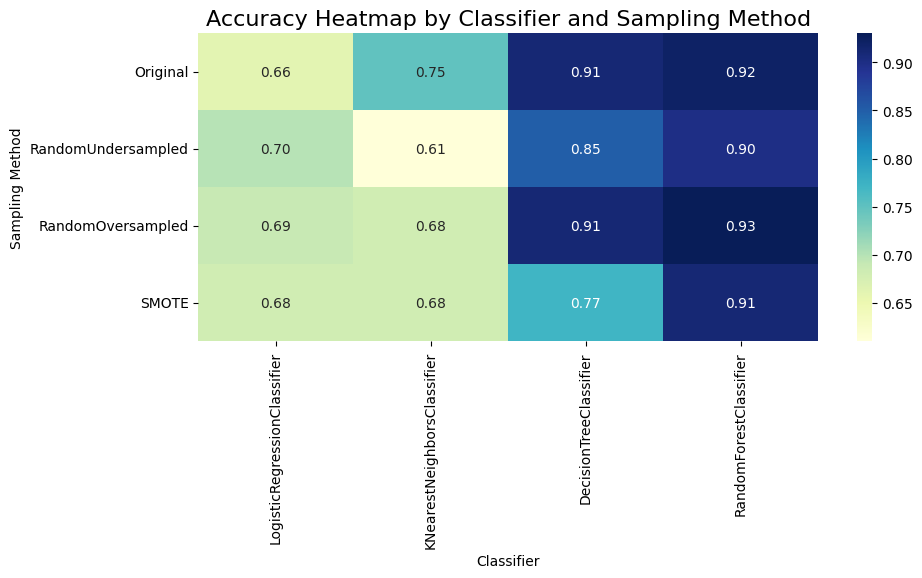

In [89]:
plt.figure(figsize=(10, 4))
sns.heatmap(df_reports_f1, annot=True, cmap='YlGnBu', cbar=True, fmt=".2f")

# Adding titles and labels
plt.title('Accuracy Heatmap by Classifier and Sampling Method', fontsize=16)
plt.xlabel('Classifier')
plt.ylabel('Sampling Method')

# Show the plot
plt.show()